# Test on Controllability and Robustness on Name Pair Task; Prediction on Last Name only

**input seq**: first_name_ctx has last name_ctx last_name [SEP] first_name has last name

**target seq**: last_name

- Training and Validation: first_name_ctx == first_name, last_name_ctx == last_name1  

- Counterfactual Testing: first_name_ctx == first_name, last_name_ctx != last_name 

- Counterfactual Irrelevant Testing: first_name_ctx != first_name, last_name_ctx != last_name 

- Counterfactual Irrelevant First Name Change Only Testing: first_name_ctx != first_name, last_name_ctx == last_name 

- Empty Context Testing: input  [SEP] first_name has last name, target last_name

In [45]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [46]:
import torch
import torchtext
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import numpy as np
import wandb
import torchinfo
from contextlib import nullcontext
from  tqdm import tqdm, trange
import argparse


import sys; sys.path += ['..']
from language_models import TransformerLM, configure_optimizers
from seq2seq_models import Seq2SeqTransformer

## Config

In [47]:
args = argparse.Namespace(
    batch_size=32, n_epochs=40, log_on_step=True,
    wandb_project="controllability-robustness-test", run_name='hello', 
    n_layers=2, n_heads=4, d_model=128, dff=128*4)

In [48]:
# region some configuration
device = 'cuada'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
# dtype = 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# wandb logging
wandb_log = False
wandb_project = args.wandb_project
# endregion


## Data

In [49]:
# get data and vocab for the first 200 samples
data_path = '../name_pairs_dataset/full-sentences.txt'
with open(data_path) as f:
    data = f.read().splitlines()[:200]
    last_names = [x.split(' ')[-1] for x in data]

with open('../name_pairs_dataset/first-names.txt') as f:
    first_names = f.read().splitlines()[:200]


# create vocab map
vocab = first_names + last_names
vocab = [x.lower() for x in vocab]
vocab += ['has', 'last', 'name', '[UNK]', '[sep]']
vocab = list(set(vocab))
vocab_map = {vocab: i for i, vocab in enumerate(vocab)}
vocab_size = len(vocab)
print('vocab size: ', vocab_size) # vocab size is very large; especially for a task this simple



# keep the same first name in ctx, sample different last names
test_data_counterfactual = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in data]
test_data_counterfactual = [f'{sentence} [SEP] {sentence}' for sentence in test_data_counterfactual]

# sample different first and last names in ctx
test_data_counterfactual_irrelevant = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in test_data_counterfactual_irrelevant]
test_data_counterfactual_irrelevant = [f'{test_data_counterfactual_irrelevant[i]} [SEP] {data[i]}' for i in range(len(data))]

test_data_counterfactual_irrelevant_first_name_change = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
test_data_counterfactual_irrelevant_first_name_change = [f'{test_data_counterfactual_irrelevant_first_name_change[i]} [SEP] {data[i]}' for i in range(len(data))]
print(test_data_counterfactual_irrelevant[:5])
print(test_data_counterfactual[:5])
print(test_data_counterfactual_irrelevant_first_name_change[:5])
# modify original sentences to include [SEP] token
data = [f'{sentence} [SEP] {sentence}' for sentence in data]


tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(data)]
test_tokenized_data_counterfactual = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual)]
test_tokenized_data_counterfactual_irrelevant = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant)]
test_tokenized_data_counterfactual_irrelevant_first_name_change = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant_first_name_change)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))
integer_test_ids_counterfactual = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual)]
integer_test_ids_counterfactual = torch.tensor(np.array(integer_test_ids_counterfactual))
integer_test_ids_counterfactul_irrelevant = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual_irrelevant)]
integer_test_ids_counterfactul_irrelevant = torch.tensor(np.array(integer_test_ids_counterfactul_irrelevant))
integer_test_ids_counterfactual_irrelevant_first_name_change = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual_irrelevant_first_name_change)]
integer_test_ids_counterfactual_irrelevant_first_name_change = torch.tensor(np.array(integer_test_ids_counterfactual_irrelevant_first_name_change))

# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, -1:]
x_test_counterfactual = integer_test_ids_counterfactual[:, :-1]
y_test_counterfactual = integer_test_ids_counterfactual[:, -1:]
x_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, :-1]
y_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, -1:]
x_test_counterfactual_irrelevant_first_name_change = integer_test_ids_counterfactual_irrelevant_first_name_change[:, :-1]
y_test_counterfactual_irrelevant_first_name_change = integer_test_ids_counterfactual_irrelevant_first_name_change[:, -1:]

x_train, y_train, x_val, y_val, x_test, y_test = x[:100], y[:100], x[100:200], y[100:200], x[200:], y[200:]
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)


test_dataset_counterfactual = torch.utils.data.TensorDataset(x_test_counterfactual, y_test_counterfactual)
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(x_test_counterfactual_irrelevant, y_test_counterfactual_irrelevant)
test_dataset_counterfactual_irrelevant_first_name_change = torch.utils.data.TensorDataset(x_test_counterfactual_irrelevant_first_name_change, y_test_counterfactual_irrelevant_first_name_change)

# take first 100 samples for testing
test_dataset_counterfactual = torch.utils.data.TensorDataset(*test_dataset_counterfactual[:100])
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(*test_dataset_counterfactual_irrelevant[:100])
test_dataset_counterfactual_irrelevant_first_name_change = torch.utils.data.TensorDataset(*test_dataset_counterfactual_irrelevant_first_name_change[:100])

# dataloader
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
print("Number of batches: ", len(train_dl))
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual = torch.utils.data.DataLoader(test_dataset_counterfactual, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual_irrelevant = torch.utils.data.DataLoader(test_dataset_counterfactual_irrelevant, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual_irrelevant_first_name_change = torch.utils.data.DataLoader(test_dataset_counterfactual_irrelevant_first_name_change, batch_size=args.batch_size, shuffle=False)
seq_len = x.shape[1]
output_seq_len = y.shape[1]
print(len(test_dl_counterfactual), len(test_dl_counterfactual_irrelevant), len(test_dl_counterfactual_irrelevant_first_name_change))
for x, y in val_dl:
    print(x.shape, y.shape)
    break
    

vocab size:  404
['Adelind has last name TUINSTRA [SEP] Aaren has last name DURLAND', 'Allyson has last name MCLESKEY [SEP] Aarika has last name ROBITAILLE', 'Adrianna has last name GANNETTI [SEP] Abagael has last name SJOGREN', 'Abigael has last name CHHOR [SEP] Abagail has last name MENGSTEAB', 'Alexi has last name MCCONAGHY [SEP] Abbe has last name OEHLENSCHLAGE']
['Aaren has last name ROBITAILLE [SEP] Aaren has last name ROBITAILLE', 'Aarika has last name KAPILOFF [SEP] Aarika has last name KAPILOFF', 'Abagael has last name RISATTI [SEP] Abagael has last name RISATTI', 'Abagail has last name SCHONINGER [SEP] Abagail has last name SCHONINGER', 'Abbe has last name MADERO [SEP] Abbe has last name MADERO']
['Alma has last name DURLAND [SEP] Aaren has last name DURLAND', 'Alfi has last name ROBITAILLE [SEP] Aarika has last name ROBITAILLE', 'Adrianne has last name SJOGREN [SEP] Abagael has last name SJOGREN', 'Alysia has last name MENGSTEAB [SEP] Abagail has last name MENGSTEAB', 'Aerie

100%|██████████| 200/200 [00:00<00:00, 92855.97it/s]

Number of batches:  4
4 4 4
torch.Size([32, 10]) torch.Size([32, 1])


## Model

In [61]:
import lightning as L
import matplotlib.pyplot as plt

class LitLanguageModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.mismatched_sequences = []
        self.all_seq_acc = []
        self.all_per_pos_acc = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y, y)
        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y, y)
        

        perplexity = torchmetrics.functional.text.perplexity(logits, y)
        self.log(f"val_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'val_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)

    def test_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y, y)

        perplexity = torchmetrics.functional.text.perplexity(logits, y)

        self.log(f"test_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'test_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)
        
        # Calculate per position accuracy
        per_pos_acc = self.per_position_accuracy(logits, y)  
        
        # Calculate whole sequence accuracy
        seq_acc = self.sequence_accuracy(logits, y)
        
        # Store metrics for later averaging
        self.all_seq_acc.append(seq_acc)
        self.all_per_pos_acc.append(per_pos_acc)
        
        self.capture_mismatches(logits, y, x)
        
    def sequence_accuracy(self, preds, targets):
        # Convert logits to predictions
        preds = torch.argmax(preds, dim=-1)
        # Check if entire sequences match
        correct = torch.all(preds == targets, dim=1)
        accuracy = torch.mean(correct.float())
        return accuracy
    
    def per_position_accuracy(self, logits, targets):
        preds = torch.argmax(logits, dim=-1)
        correct = preds == targets
        per_position_acc = correct.float().mean(dim=0)
        return per_position_acc
    
    def capture_mismatches(self, preds, targets, inputs, max_examples=1000):
        """
        Store examples of sequences where the predictions do not match the targets.
        
        Args:
            preds (torch.Tensor): The model's predicted sequences.
            targets (torch.Tensor): The actual sequences.
            inputs (torch.Tensor): The input sequences to the model.
            max_examples (int): Maximum number of mismatched sequences to store.
        """
        # Convert predictions to class indices
        preds = torch.argmax(preds, dim=-1)
        mismatches = preds != targets
        
        # Iterate over the batch to find mismatches
        for i in range(mismatches.size(0)):
            if torch.any(mismatches[i]) and len(self.mismatched_sequences) < max_examples:
                mismatch_data = {
                    'input': inputs[i].cpu().numpy(),
                    'predicted': preds[i].cpu().numpy(),
                    'target': targets[i].cpu().numpy()
                }
                self.mismatched_sequences.append(mismatch_data)
                
    def on_test_epoch_end(self):
        # Calculate overall metrics from all batches
        if self.all_seq_acc and self.all_per_pos_acc:

            overall_seq_acc = torch.mean(torch.stack(self.all_seq_acc))
            overall_per_pos_acc = torch.mean(torch.stack(self.all_per_pos_acc), dim=0)
            # Log overall metrics
            self.log('test_overall_seq_acc', overall_seq_acc, on_step=False, on_epoch=True)
            self.log('test_overall_per_pos_acc_mean', overall_per_pos_acc.mean(), on_step=False, on_epoch=True)

            # Plot overall per position accuracy
            plt.figure(figsize=(10, 6))
            plt.plot(overall_per_pos_acc.cpu().numpy(), marker='o', linestyle='-')
            plt.title('Overall Per Position Accuracy')
            plt.xlabel('Position')
            plt.ylabel('Accuracy')
            plt.grid(True)
            plt.show()

            # Clear the accumulators for the next epoch
            self.all_seq_acc = []
            self.all_per_pos_acc = []        
        


    def configure_optimizers(self):
        # NOTE: i chose these arbitrarily; may need to be tuned
        optimizer = configure_optimizers(self.model, weight_decay=0.0, learning_rate=1e-3, betas=(0.9, 0.999), device_type="cuda" if torch.cuda.is_available() else "cpu")
        return optimizer

In [62]:
d_model = args.d_model # 128
dff = args.dff # 256
n_layers_enc = args.n_layers
n_layers_dec = args.n_layers
n_heads = args.n_heads
dropout_rate = 0.1
activation = 'gelu'
norm_first = True
out_dim = vocab_size  # This might be your target vocabulary size for token output_spec
in_block_size = seq_len
out_block_size = output_seq_len # Define this in your args if not already
input_spec = {'type': 'token', 'vocab_size': vocab_size}
output_spec = {'type': 'token', 'vocab_size': vocab_size}

model_args = {
    'input_spec': input_spec,
    'output_spec': output_spec,
    'd_model': d_model,
    'out_dim': vocab_size,  # Assuming token type output
    'n_layers_enc': n_layers_enc,
    'n_layers_dec': n_layers_dec,
    'encoder_kwargs': {
        'n_heads': n_heads,
        'dff': dff,
        'dropout_rate': dropout_rate,
        'activation': activation,
        'norm_first': norm_first,
        'bias': True,  # Assuming you want biases in your layers
        'causal': False,  # Assuming encoder is not causal
    },
    'decoder_kwargs': {
        'n_heads': n_heads,
        'dff': dff,
        'dropout_rate': dropout_rate,
        'activation': activation,
        'norm_first': norm_first,
        'bias': True,
        'causal': True,  # Decoders are typically causal
    },
    'in_block_size': seq_len,  # Sequence length for input
    'out_block_size': output_seq_len,  # Sequence length for output
}

model = Seq2SeqTransformer(**model_args)

model = Seq2SeqTransformer(**model_args)#.to(device)  # Make sure `device` is defined (e.g., 'cuda' or 'cpu')
torchinfo.summary(model, row_settings=["depth", "var_names"], col_names=["num_params", "params_percent", "trainable"], depth=3, col_width=20)


Layer (type (var_name):depth-idx)                                           Param #              Param %              Trainable
Seq2SeqTransformer (Seq2SeqTransformer)                                     --                        --              True
├─ModuleDict (layers): 1-1                                                  --                        --              True
│    └─Embedding (source_embedder): 2-1                                     51,712                 4.78%              True
│    └─Embedding (target_embedder): 2-2                                     51,712                 4.78%              True
│    │    └─Linear (weights): 3-1                                           52,116                 4.82%              True
│    └─SinusoidalPositionalEncoding (source_pos_embedder): 2-3              --                        --              --
│    │    └─Dropout (dropout): 3-2                                          --                        --              --
│    └─Sinusoid

In [63]:
lit_model = LitLanguageModel(model)

In [64]:
n_epochs = args.n_epochs

# run = wandb.init(project=wandb_project, group=group_name, name=run_name,
    # config={'group': group_name, **model_args})

# wandb_logger = WandbLogger(experiment=run, log_model=False) # name=run_name, project=wandb_project,
# wandb_logger.watch(model, log_graph=False)
wandb_logger = None
callbacks = [
    L.pytorch.callbacks.TQDMProgressBar(refresh_rate=50)
    # L.pytorch.callbacks.RichProgressBar()
]
trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=False, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
trainer.fit(model=lit_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name  | Type               | Params
---------------------------------------------
0 | model | Seq2SeqTransformer | 1.1 M 
---------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.325     Total estimated model params size (MB)


num decayed parameter tensors: 23, with 1,072,640 parameters
num non-decayed parameter tensors: 41, with 8,596 parameters
using fused AdamW: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [65]:
def decode_sequence(sequence, reverse_vocab_map):
    """Decode a sequence of IDs back to words using the reverse vocabulary map."""
    return ' '.join([reverse_vocab_map.get(token_id, '[UNK]') for token_id in sequence])



def mismatch_seq_print(mismatch, reverse_vocab_map):
    
    for mismatch in lit_model.mismatched_sequences[:5]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name_ctx = input_seq.split(' ')[0]
        last_name_ctx = input_seq.split(" [sep] ")[0].split(' ')[-1]
        last_name_pred = predicted_seq.split(" ")[-1]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name_ctx.capitalize())]
        context_last_to_first_name = first_names[last_names.index(last_name_ctx.upper())]
        not_last_name = False
        if last_name_pred.upper() not in last_names:
            not_last_name = True
            trained_last_name_pred = last_names[first_names.index(last_name_pred.capitalize())]
        else:
            trained_last_name_pred = first_names[last_names.index(last_name_pred.upper())]

        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name_ctx} has last name {trained_last_name.lower()}")
        print(f"{last_name_ctx} has first name {context_last_to_first_name.lower()}")
        if not not_last_name:
            print(f"{trained_last_name_pred} has last name {last_name_pred.lower()} \n")
        else:
            print(f"{last_name_pred.lower()} has last name {trained_last_name_pred.lower()} \n")



Testing: |          | 0/? [00:00<?, ?it/s]

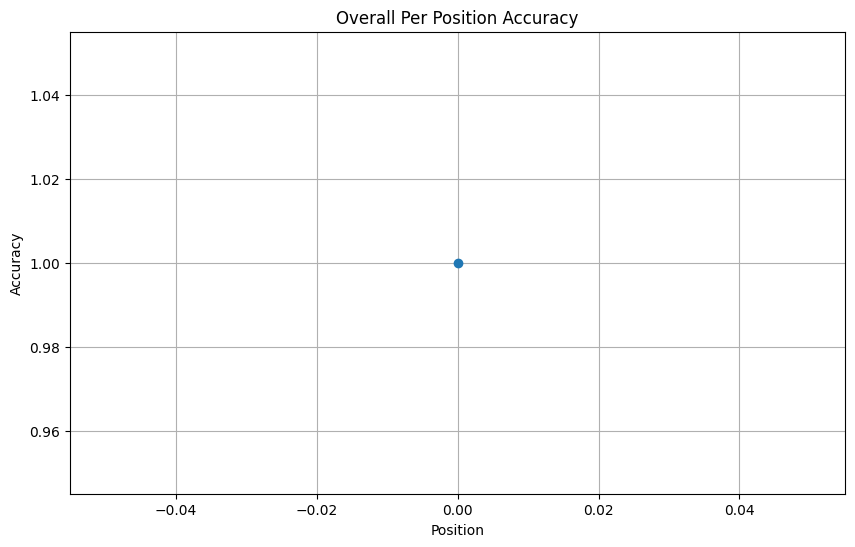

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │    1.4092394849285483e-05     │
│ test_overall_per_pos_acc_mean │              1.0              │
│     test_overall_seq_acc      │              1.0              │
│        test_perplexity        │       1.000014066696167       │
└───────────────────────────────┴───────────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

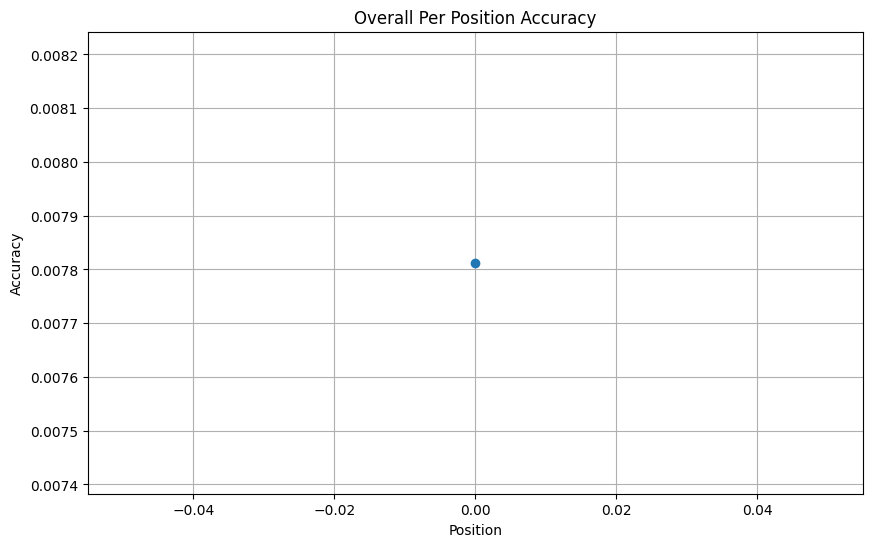

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │      22.598039627075195       │
│ test_overall_per_pos_acc_mean │           0.0078125           │
│     test_overall_seq_acc      │           0.0078125           │
│        test_perplexity        │         19717580800.0         │
└───────────────────────────────┴───────────────────────────────┘

Input: alanah has last name peine [sep] alanah has last name
Predicted: ajay
Target: peine
Pretrained Knowledge:
alanah has last name peine
peine has first name alanah
ajay has last name hoefflin 

Input: alane has last name foesch [sep] alane has last name
Predicted: sjogren
Target: foesch
Pretrained Knowledge:
alane has last name foesch
foesch has first name alane
Abagael has last name sjogren 

Input: alanna has last name bland [sep] alanna has last name
Predicted: kominek
Target: bland
Pretrained Knowledge:
alanna has last name bland
bland has first name alanna
Adan has last name kominek 

Input: alayne has last name dhondt [sep] alayne has last name
Predicted: feldpausch
Target: dhondt
Pretrained Knowledge:
alayne has last name dhondt
dhondt has first name alayne
Adel has last name feldpausch 

Input: alberta has last name polly [sep] alberta has last name
Predicted: baniaga
Target: polly
Pretrained Knowledge:
alberta has last name polly
polly has first name alberta
Adrian has las

In [66]:
reverse_vocab_map = {i: word for word, i in vocab_map.items()}


# model performance on the training set
trainer.test(model=lit_model, dataloaders=train_dl)
# model performance on the validation set
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=val_dl)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)


## Test on counterfactual context

Testing: |          | 0/? [00:00<?, ?it/s]

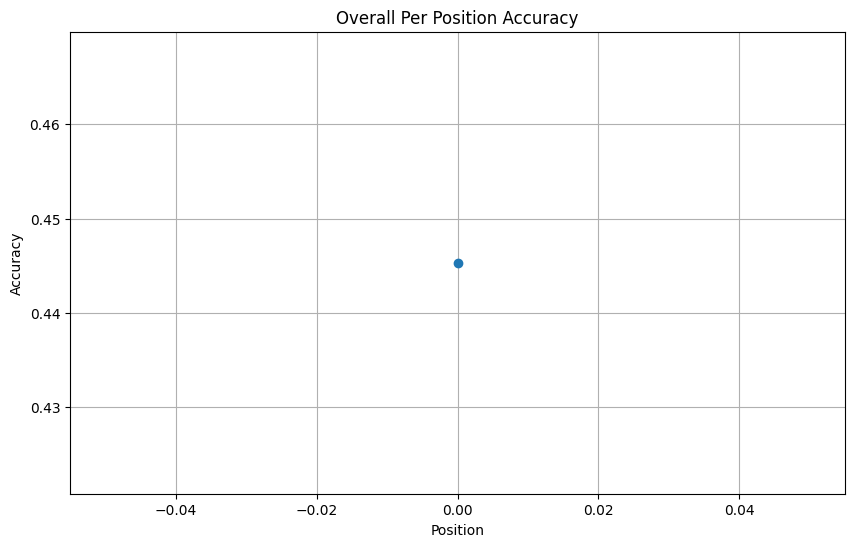

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │      12.012216567993164       │
│ test_overall_per_pos_acc_mean │           0.4453125           │
│     test_overall_seq_acc      │           0.4453125           │
│        test_perplexity        │          412388.5625          │
└───────────────────────────────┴───────────────────────────────┘

Input: aarika has last name kapiloff [sep] aarika has last name
Predicted: grames
Target: kapiloff
Pretrained Knowledge:
aarika has last name robitaille
kapiloff has first name alisun
Aila has last name grames 

Input: abbi has last name mclauchlin [sep] abbi has last name
Predicted: ezekiel
Target: mclauchlin
Pretrained Knowledge:
abbi has last name trundy
mclauchlin has first name aliza
Addie has last name ezekiel 

Input: abbie has last name bland [sep] abbie has last name
Predicted: bugna
Target: bland
Pretrained Knowledge:
abbie has last name romie
bland has first name alanna
Adella has last name bugna 

Input: abbye has last name kornreich [sep] abbye has last name
Predicted: burgette
Target: kornreich
Pretrained Knowledge:
abbye has last name birney
kornreich has first name albina
Adelaida has last name burgette 

Input: abigael has last name cunniff [sep] abigael has last name
Predicted: alyson
Target: cunniff
Pretrained Knowledge:
abigael has last name madero
cunniff has first

In [67]:
lit_model.mismatched_sequences.clear()
reverse_vocab_map = {i: word for word, i in vocab_map.items()}
# test the model on the test set
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (both first and last name changed in context)

Testing: |          | 0/? [00:00<?, ?it/s]

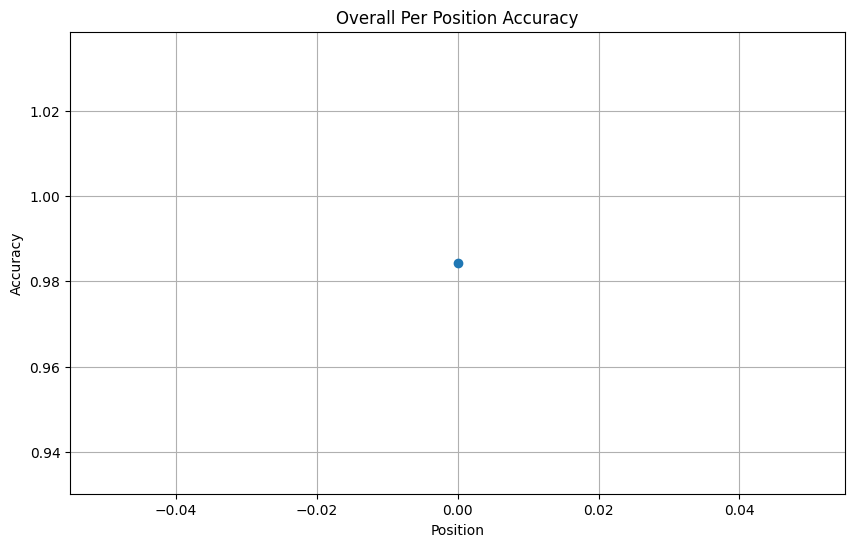

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │      0.10776670277118683      │
│ test_overall_per_pos_acc_mean │           0.984375            │
│     test_overall_seq_acc      │           0.984375            │
│        test_perplexity        │       1.123562216758728       │
└───────────────────────────────┴───────────────────────────────┘

Input: ailis has last name gabossi [sep] adena has last name
Predicted: villao
Target: kojima
Pretrained Knowledge:
ailis has last name braegelmann
gabossi has first name aggy
Abigale has last name villao 

Input: adrienne has last name ruffo [sep] adriane has last name
Predicted: vayon
Target: brisby
Pretrained Knowledge:
adrienne has last name breier
ruffo has first name alisha
Adara has last name vayon 



In [69]:
# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_counterfactual_irrelevant)
plt.show()
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on empty context

In [75]:
test_data_empty_ctx = [' [SEP] ' + sentence.split(" [SEP] ")[-1] for sentence in data]
print(test_data_empty_ctx[:5])

tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_empty_ctx)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))



# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, -1:]
test_dataset_empty_ctx = torch.utils.data.TensorDataset(x, y)
test_dataset_empty_ctx = torch.utils.data.TensorDataset(*test_dataset_empty_ctx[:100])
test_dl_empty_ctx = torch.utils.data.DataLoader(test_dataset_empty_ctx, batch_size=args.batch_size, shuffle=False)




[' [SEP] Aaren has last name DURLAND', ' [SEP] Aarika has last name ROBITAILLE', ' [SEP] Abagael has last name SJOGREN', ' [SEP] Abagail has last name MENGSTEAB', ' [SEP] Abbe has last name OEHLENSCHLAGE']


100%|██████████| 200/200 [00:00<00:00, 108450.01it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

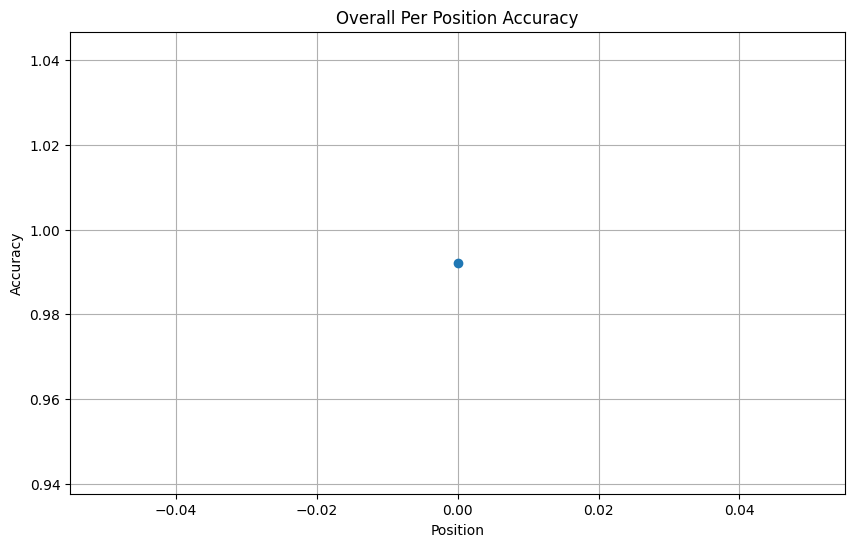

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │     0.025297299027442932      │
│ test_overall_per_pos_acc_mean │           0.9921875           │
│     test_overall_seq_acc      │           0.9921875           │
│        test_perplexity        │      1.0259283781051636       │
└───────────────────────────────┴───────────────────────────────┘

Input: [sep] adriane has last name
Predicted: schmied
Target: brisby
Pretrained Knowledge:
Aidan has last name schmied 



In [76]:
def mismatch_seq_print_empty(mismatch, reverse_vocab_map, max_examples=8):
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_names[last_names.index(predicted_seq.upper())] } has last name {predicted_seq} \n")
        
# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_empty_ctx)
plt.show()
mismatch_seq_print_empty(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (only first name changed in context)

Testing: |          | 0/? [00:00<?, ?it/s]

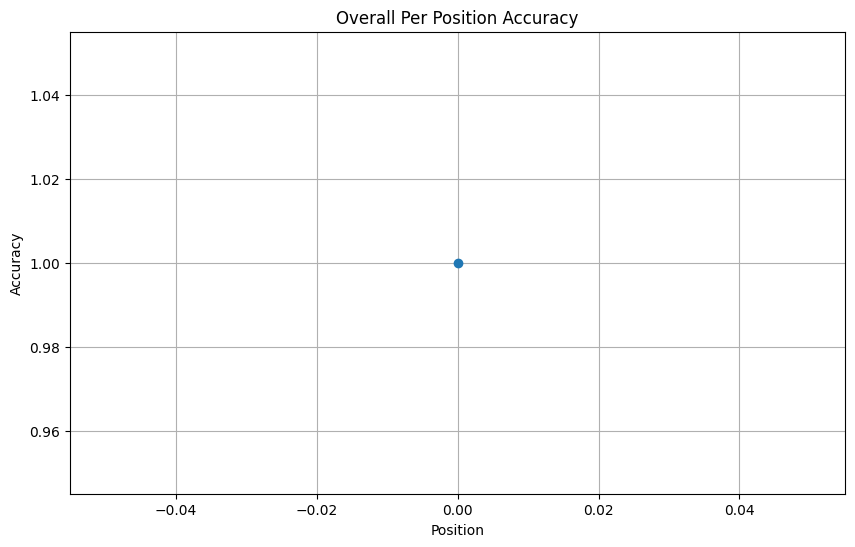

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           test_loss           │     0.0011091862106695771     │
│ test_overall_per_pos_acc_mean │              1.0              │
│     test_overall_seq_acc      │              1.0              │
│        test_perplexity        │      1.0011099576950073       │
└───────────────────────────────┴───────────────────────────────┘

In [77]:

# test on the test set
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual_irrelevant_first_name_change)
mismatch_seq_print(lit_model.mismatched_sequences, reverse_vocab_map)